# TP – Chaînes de Markov - HMMs

Mohamed SANAD

Ce TP se déroule en deux parties. La première partie concerne les chaînes de Markov et la deuxième partie traite des HMMs.

## Importation des paquets :

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from tabulate import tabulate

## Partie I :

### Rappels de cours :

➤ <b>Propriété de Markov :</b>

En probabilité, un processus stochastique vérifie la propriété de Markov si et seulement si la distribution conditionnelle de probabilité des états futurs, étant donnés les états passés et l'état présent, ne dépend en fait que de l'état présent et non pas des états passés (absence de <i>« mémoire »</i>). Un processus qui possède cette propriété est appelé processus de Markov. Pour de tels processus, la meilleure prévision qu'on puisse faire du futur, connaissant le passé et le présent, est identique à la meilleure prévision qu'on puisse faire du futur, connaissant uniquement le présent : <i>si on connait le présent, la connaissance du passé n'apporte pas d'information supplémentaire utile pour la prédiction du futur.</i>

On dit qu'un modèle possède la propriété de Markov si son état à un instant T dépend uniquement de son état à l’instant T-1. Si on peut observer les états dans lesquels se trouve le modèle à chaque instant, on parle de <i>modèle de Markov observable</i>. Sinon, on parle de <i>modèle de Markov caché.</i>

<br>

➤ <b>Chaîne de Markov :</b>

La chaîne de Markov est un modèle statistique composé d'états et de transitions. Une transition matérialise la possibilité de passer d'un état à un autre. Dans le modèle de Markov, les transitions sont unidirectionnelles : une transition de l'état A vers état B ne permet pas d'aller de l'état B vers l'état A. Tous les états ont des transitions vers tous les autres états, y compris vers eux-mêmes. Chaque transition est associée à sa probabilité d'être empruntée et cette probabilité peut éventuellement être nulle.

<br>

➤ <b>Exemple :</b>

Imaginons maintenant que nous avons 3 états (A, B et C). Une chaîne de Markov est une suite de transitions entre ces 3 états :
$$ q_1~➜~q_2~➜...➜~q_T $$

On a les probabilités initiales <i>(les probabilités de commencer dans chacun des états du modèle)</i>, et la matrice de transition <i>(une matrice 3 x 3 qui sert à présenter les probabilités de passer d'un état à un autre)</i>. La somme des probabilités des transitions partant d'un état est toujours égale à 1 (100%). Cette propriété doit toujours être vraie. En effet si la somme n'était pas égale à 1, cela signifierait qu'il existe une chances de ne pas opérer de transition, ce qui est impossible dans un modèle de Markov.

On a : $P(q_1, q_2, ..., q_T) = P(q_1).P(q_2~/~q_1).P(q_3~/~q_1,q_2)~...~P(q_T~/~q_1,q_2,...,q_{T-1})$

<br>

➤ <b>Chaîne de Markov à temps discret :</b>

En effet, la dépendance aux états passés est très limitée :

$$ P(q_t~/~q_1,q_2,...,q_{t-1}) = P(q_t~/~q_{t-1},...,q_{t-k}) $$

En pratique, on prend k ∈ {1,2}. Dans le cas de k = 1, on a : $P(q_t~/~q_1,q_2,...,q_{t-1}) = P(q_t~/~q_{t-1})$

Ce qui signifie que : $P(q_1, q_2, ..., q_T) = P(q_1).P(q_2~/~q_1).P(q_3~/~q_2)~...~P(q_T~/~q_{T-1})$

Par conséquent, l'état futur ne dépend en fait que de l'état présent.

<br>

➤ <b>Chaîne de Markov stationnaire :</b>

On suppose ici que les probabilités de transition ne varient pas dans le temps. Cela autorise à définir une matrice de probabilité de transitions $A = [a_{ij}]$ telle que :

$$ a_{ij} = P(q_t=j~/~q_{t-1}=i) = P(q_{t+k}=j~/~q_{t+k-1}=i) $$

<i>∀ i,j ∈ {A,B,C}</i>

<br>

➤ <b>Chaîne de Markov ergodique / gauche-droite :</b>

Une chaîne de Markov est dite ergodique si tout état est atteignable depuis tout autre état.

Une chaîne de Markov est dite gauche-droite si sa matrice de transition est triangulaire supérieure. Reprenons l'exemple des états A, B et C. Depuis A, on peut passer vers A, B et C. Depuis B, on peut passer vers B et C uniquement. Finalement, on peut passer, depuis l'état C, uniquement vers C lui-même.

### Réalisation du TP :

On veut générer des mots dans une langue donnée en modélisant la formation de ces mots par une chaîne de Markov. Les 28 états du modèle correspondent aux 26 lettres de l’alphabet auxquelles et on ajoute un état <i>'espace initial'</i> (état 1) et un état <i>'espace final'</i> (état 28) qui sert à terminer les mots.

La correspondance entre la valeur numérique d’un état et un caractère est la suivante : l'état 1 correspond à un espace (avant le début d’un mot) et l’état 28 à celui d’un espace en fin de mot. Les états 2 à 27 correspondent aux caractères de a à z. On pourra utiliser une structure de dictionnaire en python pour faire cette correspondance.

In [2]:
dic={1:' ', 2:'a', 3:'b', 4:'c', 5:'d', 6:'e', 7:'f', 8:'g', 9:'h', 10:'i', 11:'j', 12:'k', 13:'l', 14:'m', 15:'n', 16:'o', 
     17:'p', 18:'q', 19:'r', 20:'s', 21:'t', 22:'u', 23:'v', 24:'w', 25:'x', 26:'y', 27:'z', 28:' '}

On utilisera une chaîne de Markov ergodique entre les 26 états correspondants aux lettres de l’alphabet.

#### a. Matrice de transition :

Le fichier <i>'bigramenglish.txt'</i> contient la matrice des transitions pour l’anglais (bigrams) entre deux symboles (caractères ou espaces). Le terme générique (i,j) de la matrice de transition correspond à la probabilité de transiter vers l’état j à partir de l’état i.

In [3]:
mat_tran = np.loadtxt("bigramenglish.txt")

print("Dimensions de la matrice de transitions : ", mat_tran.shape)

Dimensions de la matrice de transitions :  (28, 28)


In [4]:
if np.allclose(mat_tran.sum(axis=1), 1, rtol=0, atol=1e-6):
    print("La somme des probabilités des transitions partant d'un état est toujours égale à 1")
else:
    print("La somme des probabilités des transitions partant d'un état n'est pas toujours égale à 1")

La somme des probabilités des transitions partant d'un état est toujours égale à 1


In [5]:
# Matrice des transitions
pd.DataFrame(mat_tran, index=range(1, mat_tran.shape[0]+1), columns=range(1, mat_tran.shape[1]+1))

,1,2,3,4,5,6,7,8,9,10,...,19,20,21,22,23,24,25,26,27,28
1,0.0,0.112687,0.043609,0.045455,0.032904,0.022094,0.041763,0.015556,0.064438,0.068920,...,0.025680,0.066916,0.164522,0.010388,0.007066,0.070502,0.000105,0.010599,0.000053,0.000000
2,0.0,0.000015,0.022934,0.033960,0.038076,0.000147,0.006174,0.024698,0.000882,0.037047,...,0.094822,0.095410,0.133486,0.011761,0.033372,0.009850,0.000588,0.019847,0.000882,0.067478
3,0.0,0.071874,0.000790,0.000079,0.000790,0.282758,0.000079,0.000079,0.000079,0.070295,...,0.047390,0.015007,0.010268,0.127162,0.001580,0.000079,0.000079,0.106627,0.000079,0.007108
4,0.0,0.136747,0.000041,0.017500,0.001221,0.136747,0.000041,0.000041,0.162794,0.073257,...,0.052501,0.000814,0.087095,0.031338,0.000041,0.000041,0.000041,0.005291,0.000041,0.019535
5,0.0,0.036241,0.000029,0.000029,0.007191,0.136911,0.000863,0.003739,0.000863,0.090028,...,0.018984,0.020134,0.000029,0.020422,0.002876,0.000863,0.000029,0.008629,0.000029,0.598844
6,0.0,0.045607,0.003171,0.018653,0.078064,0.027980,0.009606,0.007181,0.001679,0.016042,...,0.125630,0.072095,0.023317,0.000466,0.016601,0.008860,0.008394,0.015109,0.000093,0.360474
7,0.0,0.066869,0.000047,0.000047,0.000047,0.074351,0.033668,0.000047,0.000047,0.077625,...,0.090250,0.001870,0.046294,0.032733,0.000047,0.000047,0.000047,0.003273,0.000047,0.396540
8,0.0,0.065942,0.000611,0.000061,0.002442,0.128221,0.000061,0.012212,0.135548,0.062889,...,0.097081,0.026255,0.006106,0.021370,0.000061,0.000611,0.000061,0.003053,0.000061,0.315667
9,0.0,0.141975,0.000772,0.000019,0.000019,0.469715,0.000579,0.000019,0.000386,0.140239,...,0.011188,0.001736,0.024498,0.019097,0.000019,0.001157,0.000019,0.002122,0.000019,0.103009
10,0.0,0.020688,0.010501,0.076954,0.038085,0.033697,0.023666,0.034010,0.000016,0.000313,...,0.041063,0.127578,0.117547,0.000940,0.032600,0.000016,0.001097,0.000016,0.006269,0.024607


<b>➢ A quelles probabilités correspond la première ligne de la matrice de transition ? et celles de la dernière colonne ?</b>

Dans la matrice de transition, les lignes représentent les états présents tandis que les colonnes représentent les états futurs.

La première ligne de la matrice de transition correspond aux probabilités de passer vers tous les 28 états depuis l'état 1. La dernière colonne de la matrice de transition correspond aux probabilités de passer depuis chacun des 28 états vers l'état 28.

<b>➢ Pour chaque lettre de l’alphabet, indiquer la transition la plus fréquente depuis cette lettre :</b>

In [6]:
# Probabilités maximales
mat_tran.max(axis=1)[1:-1]

array([0.22051689, 0.28275808, 0.16686338, 0.59884373, 0.36047379,
       0.39653963, 0.31566736, 0.46971451, 0.24528243, 0.46979866,
       0.37225637, 0.17086033, 0.26768727, 0.29421872, 0.16035077,
       0.19473793, 0.96368715, 0.24477159, 0.43030156, 0.33937505,
       0.15036937, 0.61843409, 0.20323878, 0.20061728, 0.77582944,
       0.55662188])

In [7]:
# Etats correspondants à ces probabilités
mat_tran.argmax(axis=1)[1:-1] + 1
### On a ajouté le 1 car on commence par l'état 1 et non pas l'état 0
### A l'aide de ces indices, on pourra faire le mapping avec nos lettres en utilisant le dictionnaire 'dic'

array([15,  6, 16, 28, 28, 28, 28,  6, 15, 16, 28,  6,  6, 28, 15,  6, 22,
        6, 28,  9, 19,  6,  2, 21, 28,  6], dtype=int64)

In [8]:
print(tabulate([[dic[i+2], dic[mat_tran.argmax(axis=1)[1:-1][i]+1], mat_tran.max(axis=1)[1:-1][i]] for i in range(26)], 
               headers=['Lettre', 'Transition la plus fréquente','Probabilité']))

Lettre    Transition la plus fréquente      Probabilité
--------  ------------------------------  -------------
a         n                                    0.220517
b         e                                    0.282758
c         o                                    0.166863
d                                              0.598844
e                                              0.360474
f                                              0.39654
g                                              0.315667
h         e                                    0.469715
i         n                                    0.245282
j         o                                    0.469799
k                                              0.372256
l         e                                    0.17086
m         e                                    0.267687
n                                              0.294219
o         n                                    0.160351
p         e                                    0.1

Les cases vides représentent l'état 28 (espace en fin de mot) et non pas l'état 1. Comme vous pouvez le voir sur la matrice de transition, la première colonne ne contient que des 0, et donc il est impossible de passer vers l'état 1 depuis n'importe quel autre état.

#### b. Générer un mot :

On veut générer un mot à partir de l’état initial 1 (espace de début de mot).

<b>➢ Ecrire une fonction <i>etat_suivant</i> qui génère un état (à t+1) à partir de l’état courant (à t) et à l’aide de la matrice de transition et de la fonction de répartition :</b>

Tout d'abord, on crée une nouvelle matrice qui va nous servir pour la fonction de répartition. Au niveau de chaque ligne, on fait la somme cumulative des probabilités. Ainsi, la valeur finale est égale à la somme des probabilités (qui est égale à 1). On ajoute aussi une colonne de 0 au début.

In [9]:
pd.DataFrame(np.cumsum(np.insert(mat_tran, 0, 0., axis=1), axis=1), 
             index=range(1, mat_tran.shape[0]+1), columns=range(0, mat_tran.shape[1]+1))

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
1,0.0,0.0,0.112687,0.156296,0.201751,0.234655,0.256750,0.298513,0.314069,0.378507,...,0.669848,0.736764,0.901287,0.911675,0.918741,0.989243,0.989348,0.999947,1.000000,1.0
2,0.0,0.0,0.000015,0.022948,0.056908,0.094984,0.095131,0.101305,0.126003,0.126885,...,0.627326,0.722737,0.856223,0.867984,0.901355,0.911205,0.911793,0.931640,0.932522,1.0
3,0.0,0.0,0.071874,0.072664,0.072743,0.073533,0.356291,0.356370,0.356449,0.356528,...,0.732012,0.747018,0.757286,0.884448,0.886028,0.886107,0.886186,0.992813,0.992892,1.0
4,0.0,0.0,0.136747,0.136787,0.154288,0.155509,0.292255,0.292296,0.292336,0.455130,...,0.855765,0.856579,0.943673,0.975011,0.975052,0.975093,0.975133,0.980424,0.980465,1.0
5,0.0,0.0,0.036241,0.036270,0.036299,0.043490,0.180401,0.181264,0.185003,0.185866,...,0.348146,0.368280,0.368309,0.388731,0.391607,0.392470,0.392499,0.401128,0.401156,1.0
6,0.0,0.0,0.045607,0.048778,0.067431,0.145495,0.173475,0.183082,0.190263,0.191942,...,0.494591,0.566685,0.590002,0.590468,0.607070,0.615930,0.624324,0.639433,0.639526,1.0
7,0.0,0.0,0.066869,0.066916,0.066963,0.067010,0.141361,0.175029,0.175076,0.175123,...,0.519102,0.520973,0.567267,0.600000,0.600047,0.600094,0.600140,0.603414,0.603460,1.0
8,0.0,0.0,0.065942,0.066553,0.066614,0.069056,0.197277,0.197338,0.209549,0.345097,...,0.626755,0.653010,0.659116,0.680486,0.680547,0.681158,0.681219,0.684272,0.684333,1.0
9,0.0,0.0,0.141975,0.142747,0.142766,0.142785,0.612500,0.613079,0.613098,0.613484,...,0.848322,0.850058,0.874556,0.893654,0.893673,0.894830,0.894850,0.896971,0.896991,1.0
10,0.0,0.0,0.020688,0.031189,0.108144,0.146229,0.179926,0.203592,0.237603,0.237618,...,0.689330,0.816908,0.934456,0.935396,0.967996,0.968011,0.969109,0.969124,0.975393,1.0


On voit bien que la première colonne contient des 0 et dernière colonne contient des 1.

La fonction de répartition se définit par :
<br>$$ F_{q_{t+1}|q_t=i}~(j) = P~(q_{t+1}≤j~|~q_t=i) = \sum_{k=1}^{j}a_{ik} $$

On génère un nombre aléatoire λ entre 0 et 1 selon la loi uniforme. Imaginons que : $F(a) < λ ≤ F(b)$

Alors, l'état suivant sera l'état "b".

Si, $λ ≤ F(1)$, alors l'état suivant sera l'état initial (1). Or, puisque $F(1)$ est toujours égal à 0, on pourra jamais vérifier cette propriété. Par conséquent, on pourra jamais passer à l'état (1) depuis n'importe quel état.

In [10]:
mat_fct_rep = np.cumsum(np.insert(mat_tran, 0, 0., axis=1), axis=1)

In [11]:
def etat_suivant(etat_courant): # L'état courant est un nombre compris entre 1 et 28
    
    random_number = np.random.random() # On génère un nombre aléatoire entre 0 et 1 selon la loi uniforme
    fct_rep = mat_fct_rep[etat_courant - 1]
    etat_suivant = np.searchsorted(fct_rep, random_number)
    
    return etat_suivant

<b>➢ Afficher sur un graphique la fonction de répartition pour une ligne de la matrice de transition et expliquer son rôle pour la génération de l’état à t+1 :</b>

On prend comme exemple l'état 16 <i>(La lettre 'o')</i>. Ce qui revient à considérer la ligne d'indice 15 dans notre matrice <i>mat_fct_rep</i>.

In [12]:
fct_rep = mat_fct_rep[15]

print(fct_rep)

[0.         0.         0.00735985 0.01769496 0.03210147 0.04870028
 0.0524585  0.1805512  0.18885061 0.19260883 0.19824616 0.19840275
 0.20419668 0.23911682 0.3045725  0.46492327 0.49217037 0.50814281
 0.5082994  0.62370811 0.64985907 0.69652365 0.81208895 0.83134983
 0.86517382 0.86720952 0.87676167 0.87691826 1.        ]


In [13]:
np.random.seed(10)
random_number = np.random.random()
print("Le nombre aléatoire généré est : ", random_number)

Le nombre aléatoire généré est :  0.771320643266746


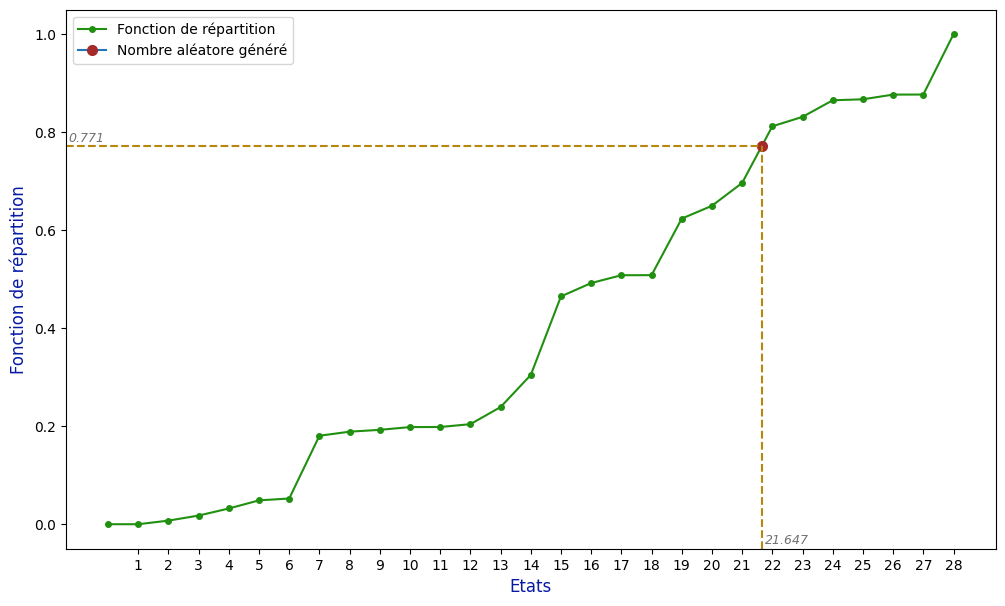

In [14]:
fig = plt.figure(figsize=(12, 7))

# La coordonnée x du point résultant de l'intersection entre la fonction y=random_number et la fonction fct_rep
random_number_x_coordinate = np.interp(random_number, fct_rep, range(0,29))

plt.plot(range(0,29), fct_rep, marker="o", markersize=4, color="#219011", label="Fonction de répartition")
plt.plot(random_number_x_coordinate, random_number, marker='o', markersize=7, 
         markeredgecolor='brown', markerfacecolor='brown', label="Nombre aléatore généré")

axes = plt.gca()
x_min, x_max = axes.get_xlim()
y_min, y_max = axes.get_ylim()

xmax = (random_number_x_coordinate - x_min) / (x_max - x_min)
ymax = (random_number - y_min) / (y_max - y_min)

plt.axhline(y=random_number, xmin=0, xmax=xmax, linestyle='--', color='darkgoldenrod')
plt.axvline(x=random_number_x_coordinate, ymin=0, ymax=ymax, linestyle='--', color='darkgoldenrod')

plt.text(x_min+0.1, random_number+0.01, str(round(random_number,3)), 
         fontstyle='italic', color='#73716F', fontsize=9)

plt.text(random_number_x_coordinate+0.1, y_min+0.01, str(round(random_number_x_coordinate,3)), 
         fontstyle='italic', color='#73716F', fontsize=9)

plt.xticks(range(1,29))

plt.xlabel("Etats", fontsize=12, color="#061AA5")
plt.ylabel("Fonction de répartition", fontsize=12, color="#061AA5")

plt.legend()

plt.show()

A partir de ce graphique, on peut dire que l'état suivant sera l'état 22 car : $21 ≤ 21.647 ≤ 22$.

En d'autres termes : $F(21) ≤ 0.771 ≤ F(22)$, avec $0.771$ qui est le nombre aléatoire généré.

On peut vérifier ça avec la fonction <i>np.searchsorted</i> :

In [15]:
print("L'état suivant est : ", np.searchsorted(fct_rep, random_number))

L'état suivant est :  22


C'est comme ça que la fonction de répartition intervient dans la détermination de l'état à t+1. En effet, à l'instant t, on génère un nombre aléatoire et on voit quels sont les états a et b qui vérifient : <i>$F(a) < nombre~aléatoire ≤ F(b)$</i>, avec F qui est la fonction de répartition de l'état à l'instant t. L'état suivant est bien évidemment l'état b.

<b>➢ Utiliser cette fonction pour écrire la fonction <i>genere_state_seq</i> qui génère une séquence d’états jusqu’à aboutir à l’état final (28) :</b>

In [16]:
def genere_state_seq():
    
    # On commence par l'état initial (1)
    sequence_etats = [1]
    etat_courant = 1
    
    # On génère un nouvel état tant que l'état courant n'est pas l'état final (28)
    while etat_courant < 28:
        etat_courant = etat_suivant(etat_courant)
        sequence_etats.append(etat_courant)
        
    return sequence_etats

In [17]:
np.random.seed(seed=None)

In [18]:
sequence_etats = genere_state_seq()
print(sequence_etats)

[1, 21, 2, 4, 16, 4, 12, 6, 6, 19, 15, 21, 9, 10, 15, 6, 5, 28]


<b>➢ Ecrire une fonction <i>display_seq</i> qui transforme une séquence d’états en séquence de caractères, à l’aide d’un dictionnaire. Utiliser ces fonctions pour générer des mots et donner des exemples de mots générés :</b>

In [19]:
def display_seq(sequence_etats):
    
    seq_etats = sequence_etats[1:-1] # On élimine l'état initial (1) et l'état final (28)
    seq_caracteres = [dic[k] for k in seq_etats] # On utilise notre dictionnaire pour transformer les états en lettres
    
    return seq_caracteres

In [20]:
print("Séquence d'états : ", sequence_etats)
print("\nSéquence de caractères : ", display_seq(sequence_etats))
print("\nMot généré : ", ''.join(display_seq(sequence_etats)))

Séquence d'états :  [1, 21, 2, 4, 16, 4, 12, 6, 6, 19, 15, 21, 9, 10, 15, 6, 5, 28]

Séquence de caractères :  ['t', 'a', 'c', 'o', 'c', 'k', 'e', 'e', 'r', 'n', 't', 'h', 'i', 'n', 'e', 'd']

Mot généré :  tacockeernthined


In [21]:
### Autres mots générés
for i in range(5):
    print(''.join(display_seq(genere_state_seq())))

w
thing
ke
chichatughrteserac
wherof


#### c. Générer une phrase :

<b>➢ On veut générer une suite de mots (phrase). Créer un état final de phrase (état 29, correspondant au caractère . ) dont la probabilité de transition vers cet état depuis un état final de mot est 0.1. Ecrire une fonction <i>modifie_mat_dic</i> qui modifie la matrice de transition et le dictionnaire en conséquence  :</b>

Pour générer une phrase, on commence par l'état initial (1), afin de générer le premier mot. Ensuite, après quelques lettres (états de 2 jusqu'à 27), on atteint l'état final du mot (28). En étant sur cet état, on est devant deux cas. Le premier cas est qu'on veut générer un deuxième mot, et donc on va devoir passer à nouveau vers l'état (1) avec une probabilité de transition de 0.9. Le deuxième cas est qu'on veut finir notre phrase avec un '.', et donc on passera vers l'état final de phrase (29) avec une probabilité de 0.1.

Ainsi, au niveau de la matrice de transition, on va d'abord ajouter une ligne et une colonne (les deux à la dernière position). Ensuite, on va changer la 28ème ligne <i>(en étant sur l'état (28), on peut passer soit vers l'état (1) avec une probabilité de transition de 0.9, soit vers l'état (29) avec une proba de 0.1)</i>.

De plus, on peut pas passer vers l'état (29) à partir des états 1 ➜ 27. Donc, la dernière colonne sera composée de 0 sauf pour l'avant dernier élément (correspondant à l'état (28)) où on aura 0.1, et pour le dernier élément (correspondant à l'état (29)) où on aura 1.

En étant sur l'état (29), qui représente la fin de la phrase, on peut pas bien sûr générer un nouveau mot. Par conséquent, on ne peut passer depuis l'état (29) que vers l'état (29) lui-même (probabilité de transition = 1).

In [22]:
def modifie_mat_dic(dic, mat_tran):
    
    dic[29] = '.'
    mat_tran[27,0] = 0.9
    mat_tran[27,27] = 0
    mat_tran = np.append(mat_tran, np.zeros((28,)).reshape(1,-1), axis=0)
    mat_tran = np.append(mat_tran, np.append(np.zeros((27,)), [0.1,1], axis=0).reshape(-1,1), axis=1)
    
    return dic, mat_tran

In [23]:
dic, mat_tran = modifie_mat_dic(dic, mat_tran)

In [24]:
print("Nouveau dictionnaire :\n\n", dic)

Nouveau dictionnaire :

 {1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 28: ' ', 29: '.'}


In [25]:
# Nouvelle matrice de transition
pd.DataFrame(mat_tran, index=range(1, mat_tran.shape[0]+1), columns=range(1, mat_tran.shape[1]+1))

,1,2,3,4,5,6,7,8,9,10,...,20,21,22,23,24,25,26,27,28,29
1,0.0,0.112687,0.043609,0.045455,0.032904,0.022094,0.041763,0.015556,0.064438,0.068920,...,0.066916,0.164522,0.010388,0.007066,0.070502,0.000105,0.010599,0.000053,0.000000,0.0
2,0.0,0.000015,0.022934,0.033960,0.038076,0.000147,0.006174,0.024698,0.000882,0.037047,...,0.095410,0.133486,0.011761,0.033372,0.009850,0.000588,0.019847,0.000882,0.067478,0.0
3,0.0,0.071874,0.000790,0.000079,0.000790,0.282758,0.000079,0.000079,0.000079,0.070295,...,0.015007,0.010268,0.127162,0.001580,0.000079,0.000079,0.106627,0.000079,0.007108,0.0
4,0.0,0.136747,0.000041,0.017500,0.001221,0.136747,0.000041,0.000041,0.162794,0.073257,...,0.000814,0.087095,0.031338,0.000041,0.000041,0.000041,0.005291,0.000041,0.019535,0.0
5,0.0,0.036241,0.000029,0.000029,0.007191,0.136911,0.000863,0.003739,0.000863,0.090028,...,0.020134,0.000029,0.020422,0.002876,0.000863,0.000029,0.008629,0.000029,0.598844,0.0
6,0.0,0.045607,0.003171,0.018653,0.078064,0.027980,0.009606,0.007181,0.001679,0.016042,...,0.072095,0.023317,0.000466,0.016601,0.008860,0.008394,0.015109,0.000093,0.360474,0.0
7,0.0,0.066869,0.000047,0.000047,0.000047,0.074351,0.033668,0.000047,0.000047,0.077625,...,0.001870,0.046294,0.032733,0.000047,0.000047,0.000047,0.003273,0.000047,0.396540,0.0
8,0.0,0.065942,0.000611,0.000061,0.002442,0.128221,0.000061,0.012212,0.135548,0.062889,...,0.026255,0.006106,0.021370,0.000061,0.000611,0.000061,0.003053,0.000061,0.315667,0.0
9,0.0,0.141975,0.000772,0.000019,0.000019,0.469715,0.000579,0.000019,0.000386,0.140239,...,0.001736,0.024498,0.019097,0.000019,0.001157,0.000019,0.002122,0.000019,0.103009,0.0
10,0.0,0.020688,0.010501,0.076954,0.038085,0.033697,0.023666,0.034010,0.000016,0.000313,...,0.127578,0.117547,0.000940,0.032600,0.000016,0.001097,0.000016,0.006269,0.024607,0.0


In [26]:
if np.allclose(mat_tran.sum(axis=1), 1, rtol=0, atol=1e-6):
    print("La somme des probabilités des transitions partant d'un état est toujours égale à 1")
else:
    print("La somme des probabilités des transitions partant d'un état n'est pas toujours égale à 1")

La somme des probabilités des transitions partant d'un état est toujours égale à 1


<b>➢ Donner des exemples de phrases générées :</b>

In [27]:
# Fonctions de répartition
pd.DataFrame(np.cumsum(np.insert(mat_tran, 0, 0., axis=1), axis=1), 
             index=range(1, mat_tran.shape[0]+1), columns=range(0, mat_tran.shape[1]+1))

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
1,0.0,0.0,0.112687,0.156296,0.201751,0.234655,0.256750,0.298513,0.314069,0.378507,...,0.736764,0.901287,0.911675,0.918741,0.989243,0.989348,0.999947,1.000000,1.0,1.0
2,0.0,0.0,0.000015,0.022948,0.056908,0.094984,0.095131,0.101305,0.126003,0.126885,...,0.722737,0.856223,0.867984,0.901355,0.911205,0.911793,0.931640,0.932522,1.0,1.0
3,0.0,0.0,0.071874,0.072664,0.072743,0.073533,0.356291,0.356370,0.356449,0.356528,...,0.747018,0.757286,0.884448,0.886028,0.886107,0.886186,0.992813,0.992892,1.0,1.0
4,0.0,0.0,0.136747,0.136787,0.154288,0.155509,0.292255,0.292296,0.292336,0.455130,...,0.856579,0.943673,0.975011,0.975052,0.975093,0.975133,0.980424,0.980465,1.0,1.0
5,0.0,0.0,0.036241,0.036270,0.036299,0.043490,0.180401,0.181264,0.185003,0.185866,...,0.368280,0.368309,0.388731,0.391607,0.392470,0.392499,0.401128,0.401156,1.0,1.0
6,0.0,0.0,0.045607,0.048778,0.067431,0.145495,0.173475,0.183082,0.190263,0.191942,...,0.566685,0.590002,0.590468,0.607070,0.615930,0.624324,0.639433,0.639526,1.0,1.0
7,0.0,0.0,0.066869,0.066916,0.066963,0.067010,0.141361,0.175029,0.175076,0.175123,...,0.520973,0.567267,0.600000,0.600047,0.600094,0.600140,0.603414,0.603460,1.0,1.0
8,0.0,0.0,0.065942,0.066553,0.066614,0.069056,0.197277,0.197338,0.209549,0.345097,...,0.653010,0.659116,0.680486,0.680547,0.681158,0.681219,0.684272,0.684333,1.0,1.0
9,0.0,0.0,0.141975,0.142747,0.142766,0.142785,0.612500,0.613079,0.613098,0.613484,...,0.850058,0.874556,0.893654,0.893673,0.894830,0.894850,0.896971,0.896991,1.0,1.0
10,0.0,0.0,0.020688,0.031189,0.108144,0.146229,0.179926,0.203592,0.237603,0.237618,...,0.816908,0.934456,0.935396,0.967996,0.968011,0.969109,0.969124,0.975393,1.0,1.0


In [28]:
mat_fct_rep = np.cumsum(np.insert(mat_tran, 0, 0., axis=1), axis=1)

################################################

def etat_suivant(etat_courant): # L'état courant est un nombre compris entre 1 et 29
    
    random_number = np.random.random() # On génère un nombre aléatoire entre 0 et 1 selon la loi uniforme
    fct_rep = mat_fct_rep[etat_courant - 1]
    etat_suivant = np.searchsorted(fct_rep, random_number)
    
    return etat_suivant

################################################

def genere_state_seq():
    
    # On commence par l'état initial (1)
    sequence_etats = [1]
    etat_courant = 1
    
    # On génère un nouvel état tant que l'état courant n'est pas l'état final de phrase (29)
    while etat_courant < 29:
        etat_courant = etat_suivant(etat_courant)
        sequence_etats.append(etat_courant)
        
    return sequence_etats

################################################

def genere_phrase(sequence_etats):
    
    # On élimine tous les états (1) car ces états représentent des espaces et ils sont soit en début de séquence, soit précédés 
    # par l'état (28) qui est aussi un espace. Du coup, on veut pas avoir un espace au début ou bien deux espaces successifs.
    seq_etats = [x for x in sequence_etats if x != 1]
    # On élimine l'avant dernier élément (qui est toujours un état (28)) car on veut pas avoir un espace avant le '.' final.
    seq_etats.pop(-2)
    # On convertit les états en caractères
    seq_caracteres = [dic[k] for k in seq_etats]
    # On génère notre phrase
    phrase = ''.join(seq_caracteres)
    
    return phrase

In [29]:
### Exemples de phrases générés
for i in range(5):
    print("\n"+genere_phrase(genere_state_seq()))


y in he oudorthe in.

ple dicedast irned ate thmam s ave oancheng dere mooranema thin as tin ats d ghald oundithimonitre.

o it the hi dean.

sungs wheve itheet we co hansung ambun canes d pl mothinduls.

bonodly won the.


#### d. Reconnaissance de la langue :

<b>➢ Charger la matrice des transitions entre caractères pour le français :</b>

In [30]:
mat_tran_fr = np.loadtxt("bigramfrancais.txt")

print("Dimensions de la matrice de transitions : ", mat_tran_fr.shape)

Dimensions de la matrice de transitions :  (28, 28)


In [31]:
if np.allclose(mat_tran_fr.sum(axis=1), 1, rtol=0, atol=1e-6):
    print("La somme des probabilités des transitions partant d'un état est toujours égale à 1")
else:
    print("La somme des probabilités des transitions partant d'un état n'est pas toujours égale à 1")

La somme des probabilités des transitions partant d'un état est toujours égale à 1


In [32]:
# Matrice des transitions
pd.DataFrame(mat_tran_fr, index=range(1, mat_tran_fr.shape[0]+1), columns=range(1, mat_tran_fr.shape[1]+1))

,1,2,3,4,5,6,7,8,9,10,...,19,20,21,22,23,24,25,26,27,28
1,0.0,0.076217,0.011726,0.070354,0.206175,0.067422,0.021497,0.010748,0.000977,0.019543,...,0.022474,0.060582,0.013680,0.034200,0.006840,0.000098,0.000098,0.000098,0.000977,0.000000
2,0.0,0.000341,0.003414,0.023899,0.003414,0.000341,0.010242,0.013657,0.000341,0.058040,...,0.054626,0.081939,0.119495,0.133151,0.020485,0.000341,0.000341,0.000341,0.000341,0.157050
3,0.0,0.030992,0.001033,0.001033,0.001033,0.020661,0.001033,0.001033,0.001033,0.289256,...,0.299587,0.010331,0.001033,0.185950,0.001033,0.001033,0.001033,0.001033,0.001033,0.001033
4,0.0,0.040241,0.000402,0.008048,0.008048,0.301811,0.000402,0.000402,0.060362,0.209256,...,0.036217,0.000402,0.040241,0.040241,0.000402,0.000402,0.000402,0.000402,0.000402,0.032193
5,0.0,0.036174,0.000402,0.000402,0.000402,0.546624,0.004019,0.000402,0.000402,0.124598,...,0.040193,0.008039,0.000402,0.056270,0.000402,0.000402,0.000402,0.000402,0.000402,0.080386
6,0.0,0.001117,0.029034,0.023451,0.005583,0.012284,0.010050,0.004467,0.000112,0.003350,...,0.089336,0.173088,0.045784,0.032384,0.006700,0.000112,0.008934,0.000112,0.001117,0.337242
7,0.0,0.088496,0.001475,0.001475,0.001475,0.176991,0.088496,0.001475,0.001475,0.265487,...,0.029499,0.044248,0.014749,0.029499,0.001475,0.001475,0.001475,0.001475,0.001475,0.001475
8,0.0,0.051348,0.001284,0.001284,0.001284,0.115533,0.001284,0.001284,0.001284,0.462131,...,0.205392,0.001284,0.001284,0.064185,0.001284,0.001284,0.001284,0.001284,0.001284,0.012837
9,0.0,0.218579,0.005464,0.005464,0.005464,0.437158,0.005464,0.005464,0.005464,0.163934,...,0.005464,0.005464,0.005464,0.005464,0.005464,0.005464,0.005464,0.005464,0.005464,0.054645
10,0.0,0.065735,0.092440,0.145850,0.004108,0.112983,0.028759,0.014380,0.000205,0.000205,...,0.032868,0.110929,0.071898,0.002054,0.018488,0.000205,0.000205,0.000205,0.000205,0.030813


<b>➢ Ecrire une fonction <i>calc_vraisemblance</i> qui calcule la vraisemblance du modèle français pour une phrase donnée
en multipliant les probabilités de transition :</b>

In [33]:
# On modifie la matrice de transition pour le modèle français comme ce qu'on a fait pour le modèle anglais :
mat_tran_fr[27,0] = 0.9
mat_tran_fr[27,27] = 0
mat_tran_fr = np.append(mat_tran_fr, np.zeros((28,)).reshape(1,-1), axis=0)
mat_tran_fr = np.append(mat_tran_fr, np.append(np.zeros((27,)), [0.1,1], axis=0).reshape(-1,1), axis=1)

La première étape consiste à changer les caractères liés aux états (1) et (28) pour différencier entre l'espace de début de mot et l'espace de fin de mot :

In [34]:
print("Ancien dictionnaire :\n\n", dic)

Ancien dictionnaire :

 {1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 28: ' ', 29: '.'}


In [35]:
dic[1] = '-'
dic[28] = '+'

In [36]:
print("Nouveau dictionnaire :\n\n", dic)

Nouveau dictionnaire :

 {1: '-', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 28: '+', 29: '.'}


On définit aussi le dictionnaire inverse (les valeurs deviennent les clés et réciproquement) :

In [37]:
dic_inv = {v: k for k, v in dic.items()}

In [38]:
print("Dictionnaire inverse :\n\n", dic_inv)

Dictionnaire inverse :

 {'-': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, '+': 28, '.': 29}


La deuxième étape consiste à créer une fonction qui pourrait transformer une phrase de la forme <i>«mot1 mot2 mot3»</i> en <i>«-mot1+-mot2+-mot3+.»</i> :

In [39]:
def transforme_phrase(phrase):
    
    mots = phrase.split()
    liste = [f"-{mot}+" for mot in mots]
    nouvelle_phrase = "".join(liste) + "."

    return nouvelle_phrase

In [40]:
### Exemple :
phrase = "reconnaissance de la langue"
nouvelle_phrase = transforme_phrase(phrase)

print(nouvelle_phrase)

-reconnaissance+-de+-la+-langue+.


La troisième étape consiste à obtenir une séquence d'états à partir de cette nouvelle phrase (en utilisant le dictionnaire inverse) :

In [41]:
sequence_etats = [dic_inv[k] for k in nouvelle_phrase]
print(sequence_etats)

[1, 19, 6, 4, 16, 15, 15, 2, 10, 20, 20, 2, 15, 4, 6, 28, 1, 5, 6, 28, 1, 13, 2, 28, 1, 13, 2, 15, 8, 22, 6, 28, 29]


Finalement, on calcule la vraisemblance de notre modèle pour cette séquence d'états.

Pour une séquence d'états $q_1 ➜ q_2 ➜ ... ➜ q_T$, la vraisemblance est tout simplement la probabilité d'obtenir cette séquence avec notre modèle markovien :

$$ P(q_1, q_2, ..., q_T) = P(q_1)~\times~P(q_2|q_1)~\times~...~\times~P(q_T|q_{T-1}) $$

Or, $q_1$ correspond toujours à l'état (1) qui est l'état de début d'un mot (en effet, toutes les phrases commencent par un '-') , donc $P(q_1)$ vaut toujours 1 :

$$ P(q_1, q_2, ..., q_T) = P(q_2|q_1)~\times~...~\times~P(q_T|q_{T-1}) = \sum_{t=2}^{T} P(q_t|q_{t-1}) = \sum_{t=2}^{T} a_{q_{t-1},q_t} $$

Par exemple, pour l'exemple ci-dessus, la vraisemblance sera égale à :

$$ P = a_{1,19}~\times~a_{19,6}~\times~...~\times~a_{28,29} $$

In [42]:
P = 1

for k in range(1,len(sequence_etats)):
    
    i = sequence_etats[k-1]
    j = sequence_etats[k]
    aij = mat_tran_fr[i-1,j-1]
    
    P *= aij
    
print("La vraisemblance du modèle français pour cette phrase est :", P)

La vraisemblance du modèle français pour cette phrase est : 1.4054599953646113e-30


Définissons maintenant notre fonction <i>calc_vraisemblance</i> :

In [43]:
def calc_vraisemblance(phrase):
    
    nouvelle_phrase = transforme_phrase(phrase)
    sequence_etats = [dic_inv[k] for k in nouvelle_phrase]
    
    vraisemblance = 1

    for k in range(1,len(sequence_etats)):

        i = sequence_etats[k-1]
        j = sequence_etats[k]
        aij = mat_tran_fr[i-1,j-1] # Modèle français

        vraisemblance *= aij
        
    return vraisemblance

In [44]:
P == calc_vraisemblance(phrase)

True

<b>➢ Calculer la vraisemblance des modèles français et anglais pour la phrase <i>« to be or not to be »</i>. De même calculer la vraisemblance des modèles français et anglais pour la phrase <i>« etre ou ne pas etre »</i> :</b>

Définissons une fonction <i>calc_vraisemblance_en</i> (identique à <i>calc_vraisemblance</i>) pour le modèle anglais :

In [45]:
def calc_vraisemblance_en(phrase):
    
    nouvelle_phrase = transforme_phrase(phrase)
    sequence_etats = [dic_inv[k] for k in nouvelle_phrase]
    
    vraisemblance = 1

    for k in range(1,len(sequence_etats)):

        i = sequence_etats[k-1]
        j = sequence_etats[k]
        aij = mat_tran[i-1,j-1] # Modèle anglais

        vraisemblance *= aij
        
    return vraisemblance

In [46]:
phrase_1 = "to be or not to be"

print("La vraisemblance du modèle français pour cette phrase : ", calc_vraisemblance(phrase_1))
print("La vraisemblance du modèle anglais pour cette phrase : ", calc_vraisemblance_en(phrase_1))

La vraisemblance du modèle français pour cette phrase :  5.9602081018686406e-30
La vraisemblance du modèle anglais pour cette phrase :  8.112892227809415e-20


In [47]:
calc_vraisemblance(phrase_1) < calc_vraisemblance_en(phrase_1)

True

In [48]:
phrase_2 = "etre ou ne pas etre"

print("La vraisemblance du modèle français pour cette phrase : ", calc_vraisemblance(phrase_2))
print("La vraisemblance du modèle anglais pour cette phrase : ", calc_vraisemblance_en(phrase_2))

La vraisemblance du modèle français pour cette phrase :  1.145706887234789e-19
La vraisemblance du modèle anglais pour cette phrase :  4.462288711775253e-24


In [49]:
calc_vraisemblance(phrase_2) > calc_vraisemblance_en(phrase_2)

True

On voit bien que la vraisemblance du modèle français pour la phrase <i>"to be or not to be"</i> est inférieure à celle du modèle anglais car c'est une phrase en langue anglaise. De même, la vraisemblance du modèle français pour la phrase <i>"etre ou ne pas etre"</i> est supérieure à celle du modèle anglais car c'est une phrase en langue française.

## Partie II :

### Rappels de cours :

➤ <b>Les HMM :</b>

Un modèle de Markov caché est basé sur un modèle de Markov, sauf qu'on ne peut pas observer directement la séquence d'états : les états sont cachés. Chaque état émet des "observations" qui, elles, sont observables. On ne travaille donc pas sur la séquence d'états, mais sur la séquence d'observations générées par les états.

Nous avons donc :

● La suite cachée correspond à la suite des états $Q = q_1, q_2, ...,q_T$, où les $q_t$ prennent leurs valeurs parmi l’ensemble des $N$ états du modèle $S = {s_1, s_2, ..., s_N}$.

● La suite observable correspond à la séquence des d’observations $O = o_1, o_2, ...,o_T$, où les $o_t$ prennent leurs valeurs parmi l’ensemble des $M$ symboles observables $V = {v_1, v_2, ..., v_M}$.

Lorsque $V$ est de taille finie, on parle de HMM discrets. Sinon, on parle de HMM continus.

Un modèle de Markov caché est défini par :

◆ Un vecteur $π$ de probabilités initiales : $π = (π_i)_{i=1, 2, ..., N}$. Pour tout état i, $π_i$ est la probabilité que l’état de départ du HMM soit l’état i : $π_i = P(q_1 = s_i)$

◆ Une matrice $A$ de probabilités de transition entre les états : $a_{ij}$ représente la probabilité que le modèle évolue de l’état i vers l’état j : 

$$ a_{ij} = P(q_{t+1} = s_j~|~q_t = s_i)~~~~∀i,j ∈ [1 ...N]~,~∀t ∈ [1 ...T] $$

◆ Une matrice $B$ de probabilités d’observation des symboles dans chacun des états du modèle : $b_{kj}$ représente la probabilité que l’on observe le symbole $v_k$ alors que le modèle se trouve dans l’état j, soit :

$$ b_{kj} = b_j(k) = P(o_t = v_k~|~q_t = s_j)~,~∀k ∈ [1 ...M]~,~∀j ∈ [1 ...N]~,~∀t ∈ [1 ...T] $$

On a les propriétés suivantes : $ \sum_{i=1}^{N} π_i = 1 ~~~;~~~ \sum_{j=1}^{N} a_{ij} = 1 ~~~;~~~ \sum_{k=1}^{M} b_{kj} = 1 $

En pratique, on utilise deux types de modèles de Markov cachés, le modèle <i>ergodique</i> et le modèle <i>gauche-droite</i>.
Le modèle ergodique est sans contrainte : toutes les transitions d’un état vers un autre sont possibles. Le modèle gauche-droite est un modèle contenant des contraintes résultant de la mise à zéro de certaines valeurs $a_{ij}$.

<br>

➤ <b>Algorithme de Viterbi :</b>

La probabilité de la suite d’observations $O=o_1, o_2, ..., o_T$, étant donné le modèle $Λ$, est égale à la somme sur toutes les suites d’états possibles $Q$ des probabilités conjointes de $O$ et de $Q$ :

$$ P(O | Λ) = \sum_{Q}P(O,Q~|~Λ) = \sum_{Q}P(O~|~Q,Λ).P(Q~|~Λ) $$

L'algorithme de Viterbi consiste à  déterminer le meilleur chemin correspondant à l’observation, c’est-à-dire de trouver dans le modèle $Λ$ la meilleure suite d’états $Q$, qui maximise la quantité :

$$ P(O,Q~|~Λ) $$

Supposons que : $$ \hat{Q} = argmax~(P(O,Q~|~Λ)) $$

Donc, pour trouver $P(O | Λ)$, on pourrait l'estimer par : $$ P(O | Λ) ≈ P(O,\hat{Q}~|~Λ) $$

On définit : $δ_t(i)$ comme la probabilité du meilleur chemin amenant à l’état $s_i$ à l’instant t, en étant guidé par les t premières observations :

$$ δ_t(i) = \underset{q_1, q_2,..., q_{t-1}}{\max}P(q_1, q_2,..., q_t=s_i~,~o_1, o_2,..., o_t~|~Λ) $$

On peut aussi démontrer que : $$ δ_{t+1}(j) = b_j(o_{t+1}).\underset{i}{\max}(δ_t(i).a_{ij}) $$

De plus, on garde trace, lors du calcul, de la suite d’états qui donne le meilleur chemin amenant à l’état $s_i$ à t dans un tableau $ψ$ :

$$ ψ_{t+1}(j) = \underset{i}{argmax}~(δ_t(i).a_{ij}) $$

Finalement, en posant : $ \hat{Q} = (\hat{q_1}, \hat{q_2}, ..., \hat{q_T}) $

On a : $$ P* = P(O,\hat{Q}~|~Λ) = \underset{j}{\max}(δ_T(j) $$

Et : $$ \hat{q_T} = \underset{j}{argmax}~(δ_T(j) $$

Et pour retrouver les autres $\hat{q_t}$, on applique : $$ \hat{q_t} = ψ_{t+1}(\hat{q_{t+1}})~~~~~~t = T-1, T-2, ..., 1 $$

### Introduction :

L’objectif de cette partie est de générer des séquences d’observations suivant un modèle de Markov Caché donné, puis de calculer la vraisemblance d’une séquence d’observations suivant un modèle de Markov Caché donné.

Le modèle de Markov est de type discret. Les classes de caractères (classes 0, 1, 7) sont modélisées chacune par un modèle à $Q=5$ états de type <i>gauche-droite</i>. Les états 1 et 5 correspondent à des colonnes de pixels de type fond de l’image (niveau 0). Les états 2, 3 et 4 correspondent au début, milieu et fin du caractère respectivement. Les transitions entre états
sont indiquées dans la matrice de transitions $A$ de taille $Q \times Q$. Les vecteurs $p$ sont tous égaux à $p=(1~0~0~0~0)$. Les séquences d’états commencent donc toujours par l’état $q_1=1$.

Les séquences d’observations sont discrètes et issues d’images de chiffres de la base MNIST. Les séquences d’observations consistent en séquences d’index (symboles) des éléments du dictionnaire. Ce dictionnaire est stocké sous forme matricielle (matrice $v$) dans le fichier <i>matrice_symboles</i>. L’élément numéro $i$ d’une séquence d’observations correspond au
symbole $i$ et donc à la colonne $i$ de la matrice $v$. Un symbole correspond à une configuration de colonne de $5$ pixels (binaires : noir/blanc). Il y a $2^5 =32$ configurations, et donc symboles possibles.

La concaténation des éléments du dictionnaire correspondant aux index de la séquence d’observations peut être visualisée sous forme d’image en remplaçant chaque index par le vecteur de pixels correspondant dans le dictionnaire.

Les probabilités des observations dans chaque état sont indiquées dans la matrice $B$ (32 lignes, 5 colonnes).

### Génération de séquences d’observations :

Les matrices <i>A0.txt, B0.txt, vect_pi0.txt</i> contiennent les matrices $A$, $B$, et le vecteur $p$ correspondant au modèle de Markov caché du chiffre $0$. Le fichier <i>matrice_symboles.txt</i> contient le dictionnaire.

<b>➢ Charger ces fichiers :</b>

In [50]:
# Matrice de transition A
A0 = np.loadtxt("data_txt_compact/A0.txt")

print("Dimensions de la matrice de transitions : ", A0.shape)

Dimensions de la matrice de transitions :  (5, 5)


In [51]:
if np.allclose(A0.sum(axis=1), 1, rtol=0, atol=1e-3):
    print("La somme des lignes est toujours égale à 1")
else:
    print("La somme des lignes n'est pas toujours égale à 1")

La somme des lignes est toujours égale à 1


In [52]:
pd.DataFrame(A0, index=range(1, A0.shape[0]+1), columns=range(1, A0.shape[1]+1))

,1,2,3,4,5
1,0.841781,0.158219,-0.000000,-0.000000,-0.000000
2,-0.000000,0.788616,0.211384,-0.000000,-0.000000
3,-0.000000,-0.000000,0.863397,0.136603,-0.000000
4,-0.000000,-0.000000,-0.000000,0.791502,0.208498
5,-0.000000,-0.000000,-0.000000,-0.000000,1.000000


In [53]:
# Matrice des probabilités d'observations B
B0 = np.loadtxt("data_txt_compact/B0.txt")

print("Dimensions de la matrice des probabilités d'observations : ", B0.shape)

Dimensions de la matrice des probabilités d'observations :  (32, 5)


In [54]:
if np.allclose(B0.sum(axis=0), 1, rtol=0, atol=1e-3):
    print("La somme des colonnes est toujours égale à 1")
else:
    print("La somme des colonnes n'est pas toujours égale à 1")

La somme des colonnes est toujours égale à 1


In [55]:
pd.DataFrame(B0, columns=range(1, B0.shape[1]+1))

,1,2,3,4,5
0,1.0,-0.000000,-0.000000,-0.000000,1.0
1,-0.0,0.000348,0.000409,0.000409,-0.0
2,-0.0,0.000348,0.000409,0.018038,-0.0
3,-0.0,0.077917,0.000409,0.129038,-0.0
4,-0.0,0.011896,0.016747,0.000409,-0.0
5,-0.0,0.000348,0.000409,0.000409,-0.0
6,-0.0,0.000348,0.002605,0.000031,-0.0
7,-0.0,0.000348,0.000409,0.000409,-0.0
8,-0.0,0.000348,0.024108,0.000409,-0.0
9,-0.0,0.000348,0.000409,0.000409,-0.0


In [56]:
# Vecteur des probabilités initiales 𝑝
p0 = np.loadtxt("data_txt_compact/vect_pi0.txt")

print("Dimensions du vecteur des probabilités initiales : ", p0.shape)

Dimensions du vecteur des probabilités initiales :  (5,)


In [57]:
print(p0)

[1. 0. 0. 0. 0.]


<b>➢ Le dictionnaire de symboles se trouve dans le fichier <i>matrice_symboles.txt</i>, charger ce fichier :</b>

In [58]:
# Dictionnaire de symboles V
V = np.loadtxt("data_txt_compact/matrice_symboles.txt")

print("Dimensions du dictionnaire de symboles : ", V.shape)

Dimensions du dictionnaire de symboles :  (5, 32)


In [59]:
pd.DataFrame(V)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


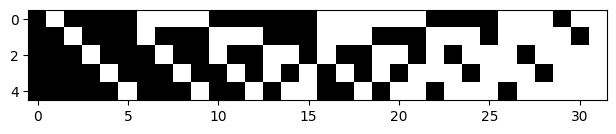

In [60]:
# Chaque colonne est associée à un symbole du dictionnaire (32 symboles en tout)
io.imshow(V)
plt.show()

<b>➢ A quoi correspondent les zéros de la matrice B ? et ceux de la matrice A et du vecteur p ?</b>

● $B = (b_{kj})_{0≤k≤31~;~1≤j≤5}$ de telle sorte que : $b_{kj}$ est la probabilité que l’on observe le symbole $k$ alors que le modèle se trouve dans l’état $j$. Ainsi, les zéros de la matrice $B$ correspondent aux symboles $k$ pour lesquels la probabilité qu'ils soient observés lorsque le modèle se trouve dans l'état $j$ vaut 0.

● $A = (a_{ij})_{1≤i,j≤5}$ de telle sorte que : $a_{ij}$ est la probabilité que le modèle évolue de l’état $i$ vers l’état $j$. Ainsi, les zéros de la matrice $A$ correspondent aux transitions qui ne peuvent jamais avoir lieu.

● Les zéros du vecteur $p$ correspondent aux états par lesquels les séquences d'états ne peuvent jamais commencer.

<b>➢ Ecrire une fonction <i>etat_suivant</i> qui génère un état qt+1 à partir de l’état courant qt à l’aide de la matrice de transitions et de la fonction de répartition :</b>

In [61]:
# Fonction de répartition
mat_fct_rep_0 = np.cumsum(np.insert(A0, 0, 0., axis=1), axis=1)

In [62]:
def etat_suivant(etat_courant): # L'état courant est un nombre compris entre 1 et 5
    
    random_number = np.random.random() # On génère un nombre aléatoire entre 0 et 1 selon la loi uniforme
    fct_rep = mat_fct_rep_0[etat_courant - 1]
    etat_suivant = np.searchsorted(fct_rep, random_number)
    
    return etat_suivant

<b>➢ Afficher la fonction de répartition pour une ligne de la matrice de transition et expliquer son rôle pour la génération de l’état à t+1 :</b>

On prend comme exemple l'état 2. Ce qui revient à considérer la ligne d'indice 1 dans notre matrice <i>mat_fct_rep_0</i>.

In [63]:
fct_rep = mat_fct_rep_0[1]

print(fct_rep)

[0.        0.        0.7886163 1.        1.        1.       ]


In [64]:
np.random.seed(77)
random_number = np.random.random()
print("Le nombre aléatoire généré est : ", random_number)

Le nombre aléatoire généré est :  0.9191090317991818


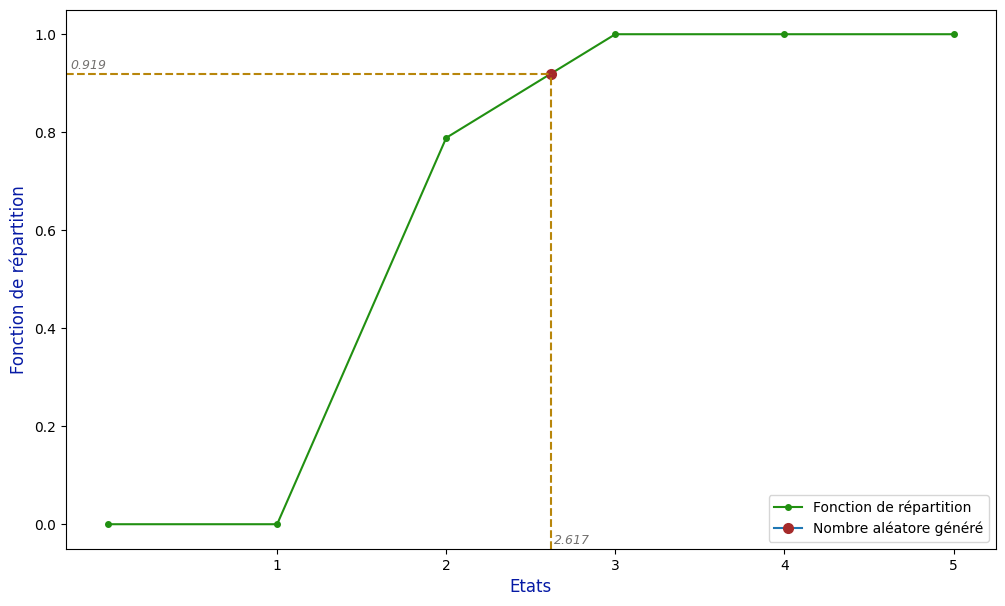

In [65]:
fig = plt.figure(figsize=(12, 7))

# La coordonnée x du point résultant de l'intersection entre la fonction y=random_number et la fonction fct_rep
random_number_x_coordinate = np.interp(random_number, fct_rep, range(0,6))

plt.plot(range(0,6), fct_rep, marker="o", markersize=4, color="#219011", label="Fonction de répartition")
plt.plot(random_number_x_coordinate, random_number, marker='o', markersize=7, 
         markeredgecolor='brown', markerfacecolor='brown', label="Nombre aléatore généré")

axes = plt.gca()
x_min, x_max = axes.get_xlim()
y_min, y_max = axes.get_ylim()

xmax = (random_number_x_coordinate - x_min) / (x_max - x_min)
ymax = (random_number - y_min) / (y_max - y_min)

plt.axhline(y=random_number, xmin=0, xmax=xmax, linestyle='--', color='darkgoldenrod')
plt.axvline(x=random_number_x_coordinate, ymin=0, ymax=ymax, linestyle='--', color='darkgoldenrod')

plt.text(x_min+0.03, random_number+0.01, str(round(random_number,3)), 
         fontstyle='italic', color='#73716F', fontsize=9)

plt.text(random_number_x_coordinate+0.02, y_min+0.01, str(round(random_number_x_coordinate,3)), 
         fontstyle='italic', color='#73716F', fontsize=9)

plt.xticks(range(1,6))

plt.xlabel("Etats", fontsize=12, color="#061AA5")
plt.ylabel("Fonction de répartition", fontsize=12, color="#061AA5")

plt.legend(loc='lower right')

plt.show()

A partir de ce graphique, on peut dire que l'état suivant sera l'état 3 car : $2 ≤ 2.617 ≤ 3$.

En d'autres termes : $F(2) ≤ 0.919 ≤ F(3)$, avec $0.919$ qui est le nombre aléatoire généré.

On peut vérifier ça avec la fonction <i>np.searchsorted</i> :

In [66]:
print("L'état suivant est : ", np.searchsorted(fct_rep, random_number))

L'état suivant est :  3


C'est comme ça que la fonction de répartition intervient dans la détermination de l'état à t+1. En effet, à l'instant t, on génère un nombre aléatoire et on voit quels sont les états a et b qui vérifient : <i>$F(a) < nombre~aléatoire ≤ F(b)$</i>, avec F qui est la fonction de répartition de l'état à l'instant t. L'état suivant est bien évidemment l'état b.

<b>➢ Générer une séquence d’observations suivant le modèle de Markov Caché du chiffre 0. On commencera par générer une séquence d’états suivant ce modèle à l’aide de la fonction <i>etat_suivant</i>. Puis on générera la séquence d’observations par le même procédé :</b>

Les séquence d'états et séquence d'observations sont de longueur $T = 28$. En effet, on travaille avec des images MNIST qui sont de taille $28 \times 28$ et qu'on peut redimensionner en $5 \times 28$ :

In [67]:
T = 28

def genere_state_seq():
    
    # On commence toujours par l'état (1) (Voir le vecteur p de probabilités initiales)
    sequence_etats = [1]
    etat_courant = 1
    
    # Le nombre d'itérations est égal à 27. A chaque itération, on génère un nouvel état. Ainsi, on aura à la fin 28 états
    for i in range(T-1):
        etat_courant = etat_suivant(etat_courant)
        sequence_etats.append(etat_courant)
        
    return sequence_etats

In [68]:
np.random.seed(seed=None)

In [69]:
sequence_etats = genere_state_seq()
print(sequence_etats)
print("\nLongueur de la séquence d'états : ", len(sequence_etats))

[1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

Longueur de la séquence d'états :  28


Pour générer la séquence d'observations, on suit le même procédé. Chaque état peut émettre un symbole parmi 32 selon une probabilité donnée. On construit ensuite notre fonction de répartition et on génère un nombre aléatoire qui nous permettra de savoir quelle symbole choisir. 

In [70]:
mat_fct_rep_symboles_0 = np.cumsum(np.insert(B0, 0, 0., axis=0), axis=0).T

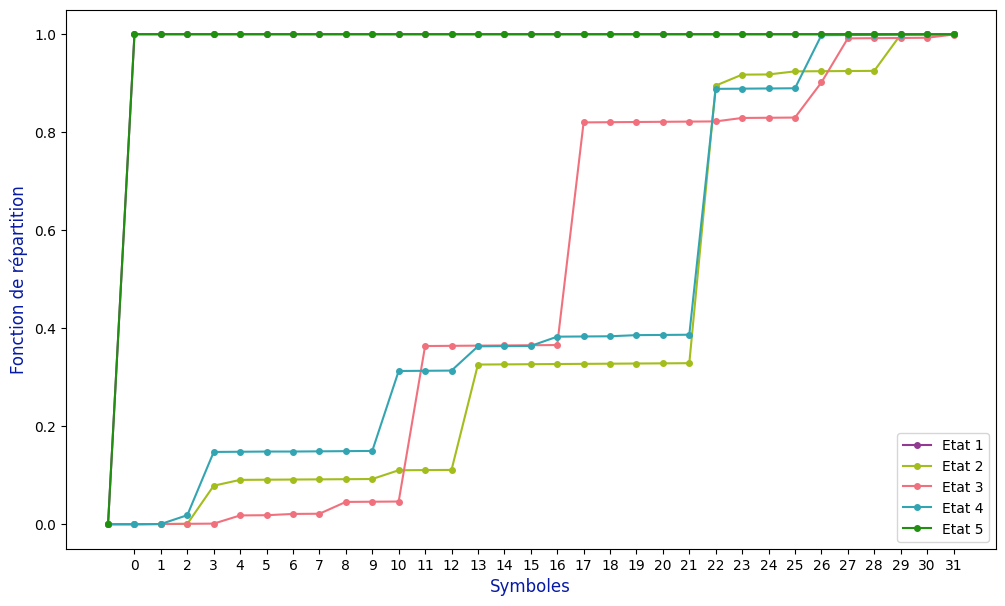

In [71]:
fig = plt.figure(figsize=(12, 7))

plt.plot(range(-1,32), mat_fct_rep_symboles_0[0], marker="o", markersize=4, color="#923A92", label="Etat 1")

plt.plot(range(-1,32), mat_fct_rep_symboles_0[1], marker="o", markersize=4, color="#A3BD1C", label="Etat 2")

plt.plot(range(-1,32), mat_fct_rep_symboles_0[2], marker="o", markersize=4, color="#F0717D", label="Etat 3")

plt.plot(range(-1,32), mat_fct_rep_symboles_0[3], marker="o", markersize=4, color="#33A5B2", label="Etat 4")

plt.plot(range(-1,32), mat_fct_rep_symboles_0[4], marker="o", markersize=4, color="#219011", label="Etat 5")

plt.xticks(range(0,32))

plt.xlabel("Symboles", fontsize=12, color="#061AA5")
plt.ylabel("Fonction de répartition", fontsize=12, color="#061AA5")

plt.legend(loc='lower right')

plt.show()

In [72]:
def genere_obs_seq(sequence_etats):
    
    sequence_observations = []
    
    for etat in sequence_etats:
        random_number = np.random.random() # On génère un nombre aléatoire entre 0 et 1 selon la loi uniforme
        fct_rep = mat_fct_rep_symboles_0[etat - 1]
        observation = np.searchsorted(fct_rep, random_number) - 1
        sequence_observations.append(observation)
        
    return sequence_observations

In [73]:
sequence_observations = genere_obs_seq(sequence_etats)
print(sequence_observations)
print("\nLongueur de la séquence d'observations : ", len(sequence_observations))

[0, 0, 0, 0, 22, 13, 22, 29, 22, 13, 22, 22, 22, 22, 13, 22, 22, 27, 17, 27, 17, 17, 25, 17, 11, 17, 11, 17]

Longueur de la séquence d'observations :  28


<b>➢ Visualiser le résultat sous forme d’image :</b>

Ensuite, on va utiliser notre matrice de symboles $V$ pour transformer les décimaux en binaires :

In [74]:
mat_seq_observations = np.array([V[:,obs] for obs in sequence_observations]).T

pd.DataFrame(mat_seq_observations)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


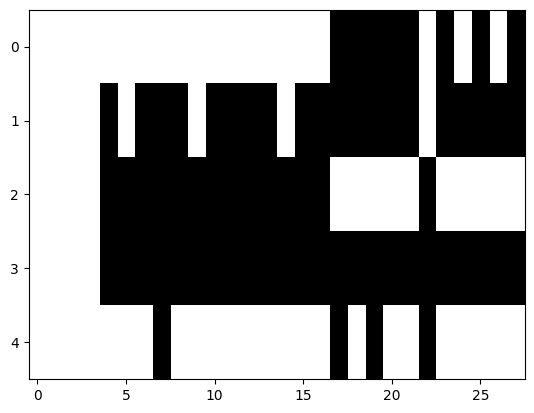

In [75]:
plt.imshow(mat_seq_observations*255, cmap='Greys', interpolation='none', aspect='auto')
plt.show()

<b>➢ Générer des séquences pour le chiffre 7 et le chiffre 1 :</b>

In [76]:
# Chiffre 1
A1 = np.loadtxt("data_txt_compact/A1.txt")
B1 = np.loadtxt("data_txt_compact/B1.txt")
p1 = np.loadtxt("data_txt_compact/vect_pi1.txt")

# Chiffre 7
A7 = np.loadtxt("data_txt_compact/A7.txt")
B7 = np.loadtxt("data_txt_compact/B7.txt")
p7 = np.loadtxt("data_txt_compact/vect_pi7.txt")

On va définir une fonction qui prend comme paramètres la matrice de transition $A$, la matrice des probabilités des observations $B$ et la longueur des séquences $T$ et retourne une séquence d'observations (en décimal et en binaire) :

In [77]:
def genere_sequence_observations(A, B, T=28):
    
############# Fonctions de répartition
    mat_fct_rep = np.cumsum(np.insert(A, 0, 0., axis=1), axis=1) # pour déterminer l'état suivant
    mat_fct_rep_symboles = np.cumsum(np.insert(B, 0, 0., axis=0), axis=0).T # pour déterminer le symbole

############# Fonctions utiles

    # Fonction etat_suivant
    def etat_suivant(etat_courant): # L'état courant est un nombre compris entre 1 et 5
        random_number = np.random.random() # On génère un nombre aléatoire entre 0 et 1 selon la loi uniforme
        fct_rep = mat_fct_rep[etat_courant - 1]
        etat_suivant = np.searchsorted(fct_rep, random_number)
        return etat_suivant
    
    # On génère une séquence d'états
    def genere_state_seq():
        sequence_etats = [1] # On commence toujours par l'état (1)
        etat_courant = 1
        for i in range(T-1): # Le nombre d'itérations est égal à T-1. On aura à la fin T états
            etat_courant = etat_suivant(etat_courant)
            sequence_etats.append(etat_courant)
        return sequence_etats
    
    # On génère une séquence d'observations à partir d'une séquence d'états
    def genere_obs_seq(sequence_etats):
        sequence_observations = []
        for etat in sequence_etats:
            random_number = np.random.random() # On génère un nombre aléatoire entre 0 et 1 selon la loi uniforme
            fct_rep = mat_fct_rep_symboles[etat - 1]
            observation = np.searchsorted(fct_rep, random_number) - 1
            sequence_observations.append(observation)
        return sequence_observations

#######################################
    
    sequence_etats = genere_state_seq()
    sequence_observations = genere_obs_seq(sequence_etats)
    
    mat_seq_observations = np.array([V[:,obs] for obs in sequence_observations]).T
    
    return sequence_observations, mat_seq_observations

Pour chaque chiffre on génère 4 séquences et on affiche les images correspondantes :

In [78]:
# Chiffre 0
seq_0_1, mat_seq_0_1 = genere_sequence_observations(A0, B0)
seq_0_2, mat_seq_0_2 = genere_sequence_observations(A0, B0)
seq_0_3, mat_seq_0_3 = genere_sequence_observations(A0, B0)
seq_0_4, mat_seq_0_4 = genere_sequence_observations(A0, B0)

# Chiffre 1
seq_1_1, mat_seq_1_1 = genere_sequence_observations(A1, B1)
seq_1_2, mat_seq_1_2 = genere_sequence_observations(A1, B1)
seq_1_3, mat_seq_1_3 = genere_sequence_observations(A1, B1)
seq_1_4, mat_seq_1_4 = genere_sequence_observations(A1, B1)

# Chiffre 7
seq_7_1, mat_seq_7_1 = genere_sequence_observations(A7, B7)
seq_7_2, mat_seq_7_2 = genere_sequence_observations(A7, B7)
seq_7_3, mat_seq_7_3 = genere_sequence_observations(A7, B7)
seq_7_4, mat_seq_7_4 = genere_sequence_observations(A7, B7)

★ <i>Chiffre 0 :</i>

In [79]:
for i in range(1,5):
    print("Séquence "+str(i)+" : ", [seq_0_1, seq_0_2, seq_0_3, seq_0_4][i-1])

Séquence 1 :  [0, 22, 22, 22, 15, 17, 27, 11, 17, 11, 11, 4, 17, 17, 11, 26, 17, 26, 17, 27, 17, 11, 17, 11, 17, 26, 11, 6]
Séquence 2 :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 29, 22, 22, 22, 13, 22, 23, 22, 22, 13, 22]
Séquence 3 :  [0, 0, 22, 22, 17, 17, 11, 17, 11, 10, 22, 13, 3, 22, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Séquence 4 :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 22, 29, 29, 22, 13, 29, 13, 22, 13, 22, 13, 22, 22, 22, 22]


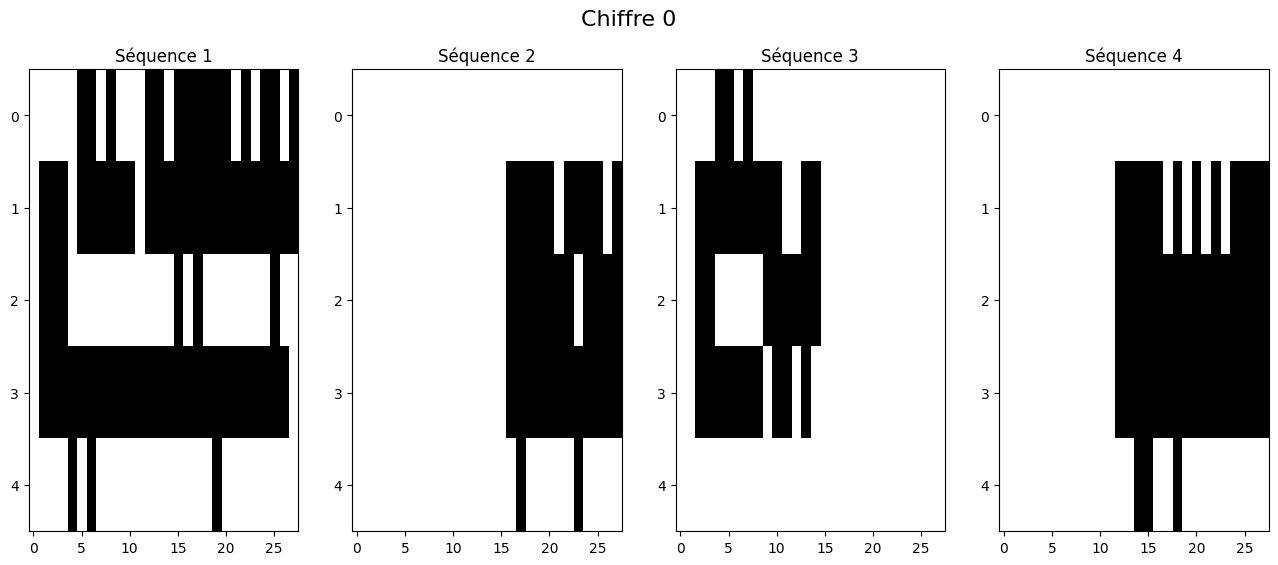

In [80]:
fig, axs = plt.subplots(1, 4, figsize=(16, 6))
fig.suptitle('Chiffre 0', fontsize=16)
for i, mat in enumerate([mat_seq_0_1, mat_seq_0_2, mat_seq_0_3, mat_seq_0_4]):
    ax = axs[i]
    ax.set_title("Séquence "+str(i+1))
    ax.imshow(mat*255, cmap='Greys', interpolation='none', aspect='auto')

★ <i>Chiffre 1 :</i>

In [81]:
for i in range(1,5):
    print("Séquence "+str(i)+" : ", [seq_1_1, seq_1_2, seq_1_3, seq_1_4][i-1])

Séquence 1 :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 26, 26, 10, 0, 0, 0, 0, 0, 0, 0]
Séquence 2 :  [0, 0, 0, 0, 0, 0, 0, 4, 13, 10, 2, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Séquence 3 :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 26, 16, 13, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Séquence 4 :  [0, 0, 0, 22, 10, 26, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


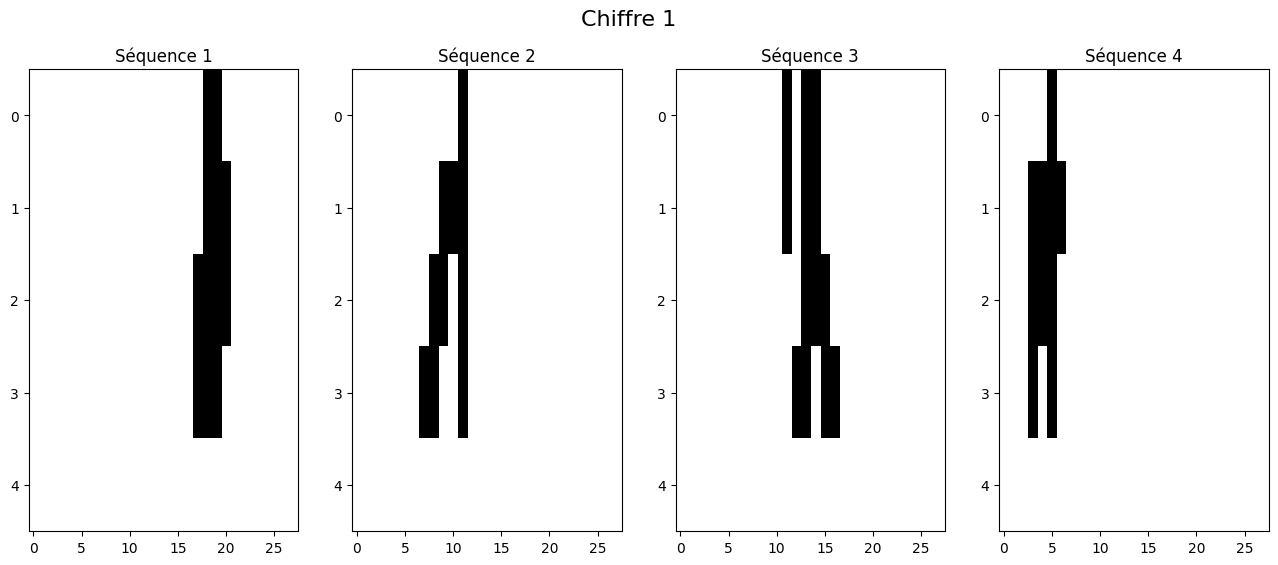

In [82]:
fig, axs = plt.subplots(1, 4, figsize=(16, 6))
fig.suptitle('Chiffre 1', fontsize=16)
for i, mat in enumerate([mat_seq_1_1, mat_seq_1_2, mat_seq_1_3, mat_seq_1_4]):
    ax = axs[i]
    ax.set_title("Séquence "+str(i+1))
    ax.imshow(mat*255, cmap='Greys', interpolation='none', aspect='auto')

★ <i>Chiffre 7 :</i>

In [83]:
for i in range(1,5):
    print("Séquence "+str(i)+" : ", [seq_7_1, seq_7_2, seq_7_3, seq_7_4][i-1])

Séquence 1 :  [0, 0, 0, 2, 29, 22, 23, 22, 22, 22, 23, 22, 29, 22, 22, 3, 3, 3, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0]
Séquence 2 :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 10, 2, 10, 2, 2, 10, 2, 11, 29, 22, 10, 10, 0, 0, 0, 0, 0, 0]
Séquence 3 :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 29, 29, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Séquence 4 :  [0, 0, 0, 0, 2, 2, 11, 23, 22, 10, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


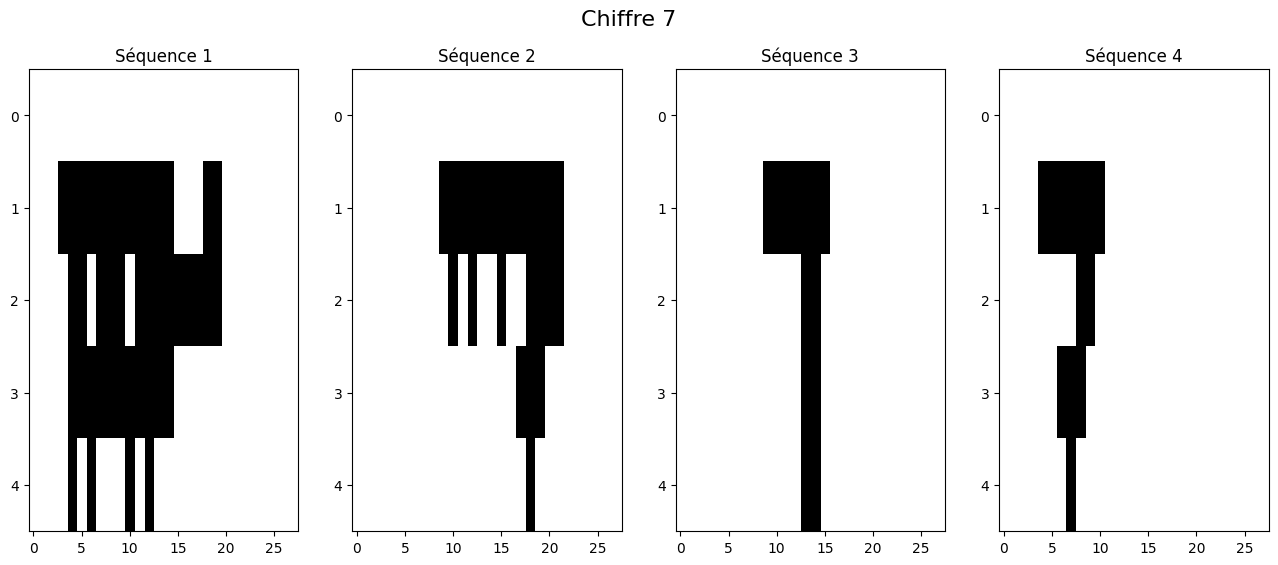

In [84]:
fig, axs = plt.subplots(1, 4, figsize=(16, 6))
fig.suptitle('Chiffre 7', fontsize=16)
for i, mat in enumerate([mat_seq_7_1, mat_seq_7_2, mat_seq_7_3, mat_seq_7_4]):
    ax = axs[i]
    ax.set_title("Séquence "+str(i+1))
    ax.imshow(mat*255, cmap='Greys', interpolation='none', aspect='auto')

###  Calcul de la vraisemblance de séquences d’observations :

Les fichiers <i>SeqTest0.txt</i>, <i>SeqTest1.txt</i>, <i>SeqTest7.txt</i> contiennent chacun 10 séquences d’observations de chiffres des 3 classes 0, 1 et 7.

In [85]:
seq_test_0 = np.loadtxt("data_txt_compact/SeqTest0.txt")
seq_test_1 = np.loadtxt("data_txt_compact/SeqTest1.txt")
seq_test_7 = np.loadtxt("data_txt_compact/SeqTest7.txt")

On a remarqué que toutes ces séquences d'observations commencent par un '1', alors qu'elles devraient commencer par un '0' (car l'état $q_1$ correspond toujours à l'état (1) et ce dernier ne peut émettre que le symbole '0'). Par conséquent, on a pensé à retrancher un 1 dans toutes les séquences.

In [86]:
seq_test_0 -= 1
seq_test_1 -= 1
seq_test_7 -= 1

<b>➢ Calculer la vraisemblance de ces séquences suivant chacun des modèles (0, 1 et 7) par l’algorithme de Viterbi :</b> 

In [87]:
def calc_vraisemblance(A, B, p, seq_obs):
    
    δ1 = np.array([])

    seq_obs = seq_obs.astype(int)
    T = len(seq_obs)

    #### Initialisation
    obs_1 = seq_obs[0]

    for i in range(5):
        δ1i = p[i]*B[obs_1,i]
        δ1 = np.append(δ1 , δ1i)

    #### Récursion
    t = 1
    δ_apres = δ1

    while t < T:
        δ_avant = δ_apres
        obs = seq_obs[t]
        δ_apres = np.array([])
        for j in range(5):
            δ_apres_j = B[obs,j] * np.max(A[:,j]*δ_avant)
            δ_apres = np.append(δ_apres , δ_apres_j)
        t += 1

    #### Terminaison
    δT = δ_apres
    P = np.max(δT)
    
    return P

★ <i>Fichier SeqTest0.txt :</i>

In [88]:
print(tabulate([[i+1, calc_vraisemblance(A0, B0, p0, seq), calc_vraisemblance(A1, B1, p1, seq), 
                 calc_vraisemblance(A7, B7, p7, seq)] for i,seq in enumerate(seq_test_0)], 
               headers=['Séquence', 'Vraisemblance du modèle 0','Vraisemblance du modèle 1', 'Vraisemblance du modèle 7']))

  Séquence    Vraisemblance du modèle 0    Vraisemblance du modèle 1    Vraisemblance du modèle 7
----------  ---------------------------  ---------------------------  ---------------------------
         1                  2.0651e-13                   4.03467e-41                  7.66265e-47
         2                  6.40082e-15                  5.45724e-40                  1.40828e-39
         3                  2.10696e-17                  1.49124e-27                  1.42124e-21
         4                  1.07221e-14                  4.6201e-52                   1.63266e-50
         5                  8.2463e-22                   2.5555e-33                   6.1249e-48
         6                  1.04885e-14                  1.1756e-35                   1.22159e-45
         7                  4.77608e-16                  1.81125e-30                  4.62983e-28
         8                  7.8109e-12                   9.90214e-33                  6.54739e-37
         9           

On remarque que la vraisemblance du modèle 0 est toujours la plus élevée.

★ <i>Fichier SeqTest1.txt :</i>

In [89]:
print(tabulate([[i+1, calc_vraisemblance(A0, B0, p0, seq), calc_vraisemblance(A1, B1, p1, seq), 
                 calc_vraisemblance(A7, B7, p7, seq)] for i,seq in enumerate(seq_test_1)], 
               headers=['Séquence', 'Vraisemblance du modèle 0','Vraisemblance du modèle 1', 'Vraisemblance du modèle 7']))

  Séquence    Vraisemblance du modèle 0    Vraisemblance du modèle 1    Vraisemblance du modèle 7
----------  ---------------------------  ---------------------------  ---------------------------
         1                  3.35523e-31                  6.92937e-24                  3.18986e-32
         2                  1.9572e-09                   1.87312e-06                  4.45525e-13
         3                  3.24819e-14                  7.32431e-11                  9.58158e-18
         4                  1.37888e-08                  1.24175e-06                  9.04962e-16
         5                  1.36949e-11                  1.1017e-06                   6.9285e-16
         6                  7.87863e-30                  6.54435e-20                  4.69902e-28
         7                  9.49706e-16                  1.62327e-13                  4.84602e-16
         8                  6.10893e-16                  1.22572e-14                  2.71958e-20
         9           

On remarque que la vraisemblance du modèle 1 est toujours la plus élevée.

★ <i>Fichier SeqTest7.txt :</i>

In [90]:
print(tabulate([[i+1, calc_vraisemblance(A0, B0, p0, seq), calc_vraisemblance(A1, B1, p1, seq), 
                 calc_vraisemblance(A7, B7, p7, seq)] for i,seq in enumerate(seq_test_7)], 
               headers=['Séquence', 'Vraisemblance du modèle 0','Vraisemblance du modèle 1', 'Vraisemblance du modèle 7']))

  Séquence    Vraisemblance du modèle 0    Vraisemblance du modèle 1    Vraisemblance du modèle 7
----------  ---------------------------  ---------------------------  ---------------------------
         1                  4.79582e-39                  3.78911e-36                  7.24393e-15
         2                  3.52741e-24                  1.99169e-25                  2.26671e-14
         3                  1.20076e-26                  2.32321e-19                  1.10214e-21
         4                  5.55702e-31                  1.55586e-32                  3.29063e-19
         5                  1.02947e-39                  8.69582e-26                  3.50141e-11
         6                  1.12399e-16                  1.11253e-25                  1.59252e-13
         7                  7.86325e-41                  2.84173e-34                  9.023e-10
         8                  6.37174e-26                  4.60546e-23                  4.47282e-21
         9            

On remarque que la vraisemblance du modèle 7 est toujours la plus élevée, sauf pour la troisième séquence.

<b>➢ Donner le résultat de la classification des images de test en considérant un problème à trois classes : 0, 1 et 7 :</b>

La classe affectée à une image est liée à au modèle pour lequel on a la vraisemblance maximale pour la séquence d'observations.

In [91]:
def classer(seq_obs):
    
    classes = [0,1,7]
    
    vraisemblance_0 = calc_vraisemblance(A0, B0, p0, seq_obs)
    vraisemblance_1 = calc_vraisemblance(A1, B1, p1, seq_obs)
    vraisemblance_7 = calc_vraisemblance(A7, B7, p7, seq_obs)

    vraisemblances = [vraisemblance_0, vraisemblance_1, vraisemblance_7]
    
    classe = classes[np.argmax(vraisemblances)]
    
    return classe

In [92]:
Classes_seq_test_0 = []

for seq in seq_test_0:
    Classes_seq_test_0.append(classer(seq))

my_list = [classe == 0 for classe in Classes_seq_test_0]
print("Classe = 0 ? ➜ ", my_list)

false_count = my_list.count(False)
total_count = len(my_list)

false_percentage = false_count/total_count * 100

print("\nTaux d'erreur : {}%".format(false_percentage))

Classe = 0 ? ➜  [True, True, True, True, True, True, True, True, True, True]

Taux d'erreur : 0.0%


In [93]:
Classes_seq_test_1 = []

for seq in seq_test_1:
    Classes_seq_test_1.append(classer(seq))

my_list = [classe == 1 for classe in Classes_seq_test_1]
print("Classe = 1 ? ➜ ", my_list)

false_count = my_list.count(False)
total_count = len(my_list)

false_percentage = false_count/total_count * 100

print("\nTaux d'erreur : {}%".format(false_percentage))

Classe = 1 ? ➜  [True, True, True, True, True, True, True, True, True, True]

Taux d'erreur : 0.0%


In [94]:
Classes_seq_test_7 = []

for seq in seq_test_7:
    Classes_seq_test_7.append(classer(seq))

my_list = [classe == 7 for classe in Classes_seq_test_7]
print("Classe = 7 ? ➜ ", my_list)

false_count = my_list.count(False)
total_count = len(my_list)

false_percentage = false_count/total_count * 100

print("\nTaux d'erreur : {}%".format(false_percentage))

Classe = 7 ? ➜  [True, True, False, True, True, True, True, True, True, True]

Taux d'erreur : 10.0%
